# UK E-Commerce Customers 

The Dataset can be found [here](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

Chen, D (2012). Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. Journal of Database Marketing and Customer Strategy Management. 19 (3), pp. 197-208.

This is a transnational data set which contains all the transactions occurring between ***01/12/2010*** and ***09/12/2011*** for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

This dataframe contains 8 variables that correspond to:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter **'c'**, it indicates a **cancellation**.
* StockCode: Product (item) code. Nominal, a **5-digit integral number** uniquely assigned to each **distinct product**.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in **sterling**.
* CustomerID: Customer number. Nominal, a 5-digit integral number **uniquely** assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

## Packages and Data import


In [328]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio

from IPython.display import SVG, display, Image

import kaleido
#from IPython.core.display import HTML

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

In [2]:
schema = {"InvoiceNo": str, "StockCode": str, "Description": str, "Quantity": "int64",
          "UnitPrice": float, "CustomerID": str, "Country": str}

df_initial = pd.read_csv("E-Commerce_uk.csv", encoding= 'unicode_escape', dtype = schema, parse_dates=['InvoiceDate'])

In [3]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Data Cleaning and Preprocessing

In [4]:
df_initial.shape

(541909, 8)

In [5]:
df_initial.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df_initial.dropna(axis = 0,inplace=True)

In [7]:
df_initial.shape

(406829, 8)

In [436]:
describe_quant = [0.01, 0.05, 0.25, 0.75, 0.95, 0.99]

In [437]:
df_initial.describe(describe_quant)

,Quantity,UnitPrice
count,401564.000000,401564.000000
mean,12.149911,3.474410
std,249.512649,69.767501
min,-80995.000000,0.001000
1%,-2.000000,0.210000
5%,1.000000,0.420000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
95%,36.000000,8.500000


In [9]:
# Checking for Unit Price equal to 0
df_initial[df_initial.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom


In [10]:
len(df_initial[df_initial.UnitPrice == 0])

40

In [11]:
df_initial = df_initial[~df_initial.UnitPrice.isin([0])]

In [12]:
df_initial.duplicated().sum()

5225

In [13]:
df_initial.drop_duplicates(inplace=True)

In [14]:
df_initial.shape

(401564, 8)

In [15]:
len(df_initial['StockCode'].value_counts())

3684

In [16]:
summary = pd.DataFrame([{'Products': len(df_initial['StockCode'].value_counts()),    
                       'Transactions': len(df_initial['InvoiceNo'].value_counts()),
                       'Customers': len(df_initial['CustomerID'].value_counts()),  
                      }], columns = ['Products', 'Transactions', 'Customers'], index = ['quantity'])
summary

,Products,Transactions,Customers
quantity,3684,22186,4371


### Deleting Cancelled Orders and correcting Order Quantities


In [17]:
# Calculating the number and percentage of cancelled orders, which start with capital C
all_orders = df_initial.InvoiceNo.nunique()
cancelled_orders = df_initial[df_initial.InvoiceNo.str.startswith("C")]["InvoiceNo"].nunique()

print("Number of cancelled orders is ", cancelled_orders)
print("Percentage of cancelled orders is %.2f percent" %((cancelled_orders/all_orders)*100))



Number of cancelled orders is  3654
Percentage of cancelled orders is 16.47 percent


In [18]:
df_initial[df_initial.InvoiceNo.str.startswith("C")].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [19]:
# Checking for StockCodes that contain only letters
StockCodeList = [df_initial[df_initial['StockCode'].str.contains('^[a-zA-Z]+', regex=True)].StockCode.unique()]
StockCodeList[:][0]

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [20]:
StockCodedf = df_initial[df_initial.StockCode.isin(StockCodeList[:][0])]
StockCodedf.count()

InvoiceNo      1908
StockCode      1908
Description    1908
Quantity       1908
InvoiceDate    1908
UnitPrice      1908
CustomerID     1908
Country        1908
dtype: int64

In [21]:
# Checking the number of orders that have been cancelled with one of the above mentioned stockcodes
StockCodedf[StockCodedf.Quantity<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527,United Kingdom
13052,C537414,POST,POSTAGE,-1,2010-12-06 15:09:00,4.41,16861,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340,United Kingdom
...,...,...,...,...,...,...,...,...
528087,C580726,CRUK,CRUK Commission,-1,2011-12-05 17:17:00,1100.44,14096,United Kingdom
531616,C580957,POST,POSTAGE,-1,2011-12-06 14:23:00,4.50,12839,United Kingdom
533082,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971,United Kingdom
534308,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490,United Kingdom


In [22]:
# Number of entries that contain a cancelled order
df_initial[df_initial.InvoiceNo.str.startswith("C")]["InvoiceNo"].count()

8872

In most cases if an order has been cancelled, the stockcode refers to a product. In few cases we have a different StockCode such as "D" for "Discount" or "M" for "Manual". In the following I will try to identify the counterparts of these orders, so I can drop both. Given the size of the dataset, I will try reducing the size by creating a new dataset that only contains the customers, that have at least one cancelled order.  

In [23]:
# Getting the Customers that cancelled an order
CustomersCO = df_initial[(df_initial.InvoiceNo.str.startswith("C"))]["CustomerID"].unique()
len(CustomersCO)

1589

In [24]:
# Percentage of Customers how has at least one cancelled order
len(CustomersCO)/summary.Customers[0] 

0.36353237245481584

In [25]:
# Creating a new dataset with the entries of these customers

df_CustomersCO =df_initial[df_initial.CustomerID.isin(CustomersCO)]
len(df_CustomersCO)

251474

In [26]:
# Size of new dataset
len(df_CustomersCO)/len(df_initial)

0.6262364156149456

In [27]:
df_CustomersCO.sort_values("CustomerID").head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
365172,568699,22634,CHILDS BREAKFAST SET SPACEBOY,2,2011-09-28 14:58:00,9.95,12352,Norway
349398,567505,23298,SPOTTY BUNTING,3,2011-09-20 14:34:00,4.95,12352,Norway
349399,567505,84510A,SET OF 4 ENGLISH ROSE COASTERS,10,2011-09-20 14:34:00,1.25,12352,Norway


We see above that the cancelled order has been cancelled on the same day, however an order could be cancelled the next day or
 even more due to a holiday for example. So it is safe to assume that the **InvoiceDate** of the cancelled order is after or in 
 this case "bigger" than its counterpart. 


In [28]:
df_cco = df_CustomersCO.copy(deep = True)
df_cco['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtful_entry = []

In [29]:
for row in df_CustomersCO.itertuples():
    if row[4] > 0 : continue 
        
    df_test = df_CustomersCO[(df_CustomersCO['CustomerID'] == row[7]) &
                    (df_CustomersCO['StockCode']  == row[2]) &
                    (df_CustomersCO['InvoiceDate'] < row[5]) &
                    (df_CustomersCO['Quantity']   > 0)].copy()
    
    
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(getattr(row, 'Index'))
    #________________________________
    # Cancelation WITH a counterpart
    if (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cco.loc[index_order, 'QuantityCanceled'] = -row[4]
        entry_to_remove.append(index_order)
        entry_to_remove.append(getattr(row, 'Index'))

    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for val in df_test.itertuples():
            if val[4] < -row[4]: continue
            ind = getattr(val, 'Index')
            df_cco.loc[ind, 'QuantityCanceled'] = -row[4]
            entry_to_remove.append(getattr(val, 'Index'))
            entry_to_remove.append(getattr(row, 'Index'))

            break 

    #print(getattr(row, 'Index'))

In [30]:
print("Number of entries to remove is" , len(entry_to_remove))
print("Number of doubtful entries to remove is" , len(doubtful_entry))


Number of entries to remove is 15042
Number of doubtful entries to remove is 1303


In [31]:
# Percentage of partial orders, which were completely cancelled, i.e. 10 units were ordererd but completely
# cancelled afterwards.
s= df_cco.loc[entry_to_remove].groupby(['CustomerID','StockCode', "UnitPrice"]).Quantity.transform('sum').eq(0)
(len(df_cco.loc[entry_to_remove][s])/2)/len(df_initial[(df_initial.InvoiceNo.str.startswith("C"))])

0.28054553651938685

In [32]:
len(df_cco.loc[entry_to_remove][~s])

10064

In [33]:
df_cco.drop(df_cco.loc[entry_to_remove][s].index, axis=0, inplace=True)

In [34]:
df_cco.Quantity = df_cco.Quantity-df_cco.QuantityCanceled

In [35]:
df_cco.sort_values("QuantityCanceled", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
169123,551162,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,240,2011-04-26 15:45:00,0.21,12901,United Kingdom,960
384013,570097,22273,FELTCRAFT DOLL MOLLY,0,2011-10-07 12:05:00,2.30,16029,United Kingdom,720
19871,537899,22328,ROUND SNACK BOXES SET OF 4 FRUITS,864,2010-12-09 10:44:00,2.55,12755,Japan,624
304421,563575,21871,SAVE THE PLANET MUG,248,2011-08-17 15:05:00,1.06,17949,United Kingdom,576
244416,558526,23170,REGENCY TEA PLATE ROSES,144,2011-06-30 11:01:00,1.45,17949,United Kingdom,576


In [36]:
df_cco.sort_values("QuantityCanceled", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
169123,551162,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,240,2011-04-26 15:45:00,0.21,12901,United Kingdom,960
384013,570097,22273,FELTCRAFT DOLL MOLLY,0,2011-10-07 12:05:00,2.30,16029,United Kingdom,720
19871,537899,22328,ROUND SNACK BOXES SET OF 4 FRUITS,864,2010-12-09 10:44:00,2.55,12755,Japan,624
304421,563575,21871,SAVE THE PLANET MUG,248,2011-08-17 15:05:00,1.06,17949,United Kingdom,576
244416,558526,23170,REGENCY TEA PLATE ROSES,144,2011-06-30 11:01:00,1.45,17949,United Kingdom,576


In [37]:
df1 = df_initial.drop(index=df_CustomersCO.index, axis=0)
df2 = df_cco[df_cco.Quantity > 0]
df_clean = pd.concat([df1, df2]).drop(columns="QuantityCanceled").sort_index()
del df1, df2

In [38]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Data Exploration and Visualization 

In [39]:
# Calculating spent money per order
df_clean["TotalExp"] = df_clean.Quantity*df_clean.UnitPrice

In [40]:
df_clean.replace(["EIRE", "RSA", "Channel Islands","USA"],
                 ["Ireland","South Africa", "Cayman Islands", "United States"], inplace=True)

### Sales Analysis (Country, Monthly, Daily)

In [41]:
grouped_country = df_clean.groupby("Country", as_index=False)["TotalExp"].sum()\
                            .rename(columns = {'TotalExp':'TotalRevenues'})\
                            .sort_values('TotalRevenues', ascending = False)

In [108]:
grouped_country["TotalRevenues %"] = (grouped_country["TotalRevenues"]/sum(grouped_country.TotalRevenues))*100
grouped_country["TotalRevenues % (cum)"] = grouped_country["TotalRevenues %"].cumsum()
grouped_country

,Country,TotalRevenues,TotalRevenues %,TotalRevenues % (cum)
34,United Kingdom,6836025.464,81.418271,81.418271
23,Netherlands,284937.540,3.393656,84.811927
16,Ireland,255273.910,3.040357,87.852284
13,Germany,223448.480,2.661311,90.513595
12,France,201014.690,2.394120,92.907716
0,Australia,136950.250,1.631102,94.538817
30,Spain,57616.900,0.686227,95.225045
32,Switzerland,55743.750,0.663918,95.888963
3,Belgium,40891.040,0.487020,96.375982
31,Sweden,37781.910,0.449989,96.825971


In [94]:

Rest = {"Country": "Rest", "TotalRevenues":sum(grouped_country.TotalRevenues) - sum(grouped_country.head(10)["TotalRevenues"]),
       "TotalRevenues %": sum(grouped_country["TotalRevenues %"]) - sum(grouped_country.head(10)["TotalRevenues %"]),
       "TotalRevenues % (cum)": 100}
grouped_country_10 = grouped_country.head(10).append(Rest, ignore_index=True)
grouped_country_10
#assert sum(grouped_country_10["TotalRevenues"]) == sum(grouped_country["TotalRevenues"])

<ipython-input-94-b995a52dc22c>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Country,TotalRevenues,TotalRevenues %,TotalRevenues % (cum)
0,United Kingdom,6836025.464,81.418271,81.418271
1,Netherlands,284937.540,3.393656,84.811927
2,Ireland,255273.910,3.040357,87.852284
3,Germany,223448.480,2.661311,90.513595
4,France,201014.690,2.394120,92.907716
5,Australia,136950.250,1.631102,94.538817
6,Spain,57616.900,0.686227,95.225045
7,Switzerland,55743.750,0.663918,95.888963
8,Belgium,40891.040,0.487020,96.375982
9,Sweden,37781.910,0.449989,96.825971


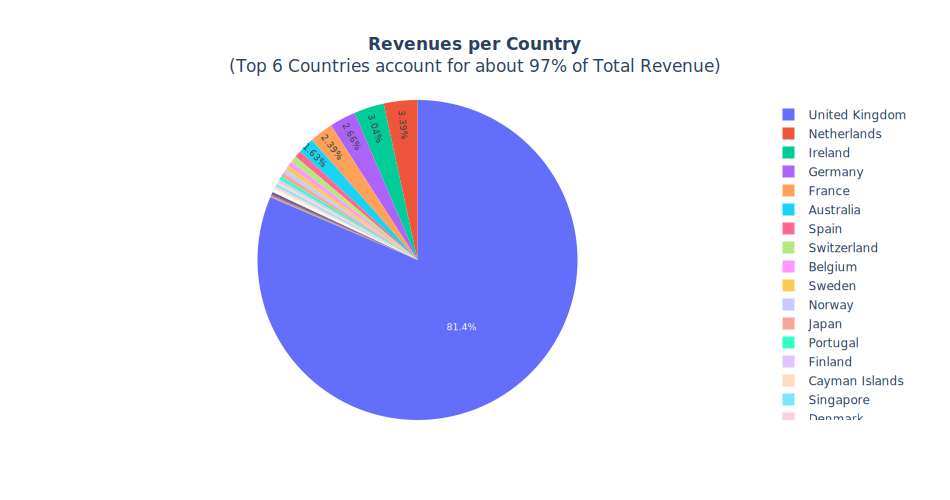

In [447]:
fig = px.pie(grouped_country, values="TotalRevenues" , names= "Country", 
             title = "<b>Revenues per Country</b><br>(Top 6 Countries account for about {}% of Total Revenue)"
             .format(int(round(grouped_country.iloc[9, ]["TotalRevenues % (cum)"], 0))))
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize = 6, title_x=0.5, uniformtext_mode='hide', width = 950)
fig.show("svg")


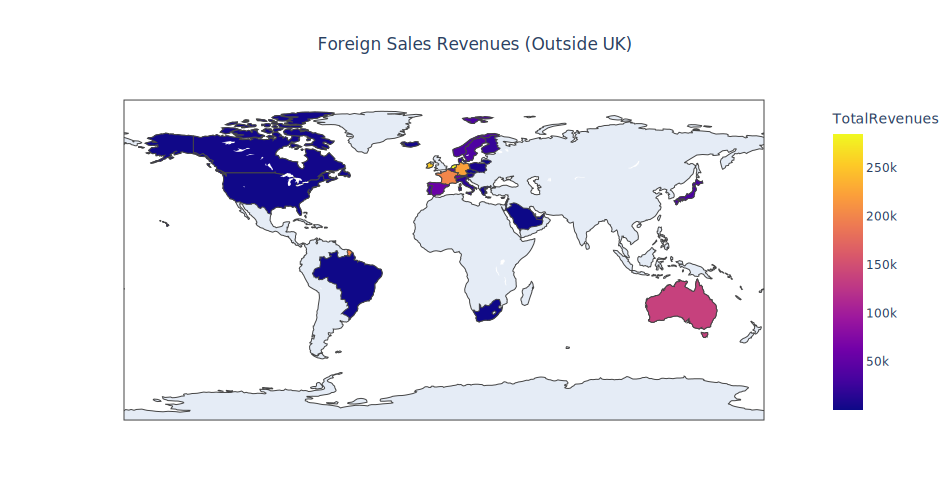

In [448]:
fig = px.choropleth(grouped_country[~(grouped_country.Country=="United Kingdom")], locations="Country", locationmode = "country names",
                    color="TotalRevenues", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                   title = "Foreign Sales Revenues (Outside UK)")
fig.update_layout(title_x=0.5, width = 950)
fig.show("svg")


In [109]:
grouped_sales =df_clean.loc[:, ("CustomerID","InvoiceNo", "Quantity", "InvoiceDate", "TotalExp")]
grouped_sales.insert(4, "Year", df_clean['InvoiceDate'].dt.year)
grouped_sales.insert(5, "Month", df_clean['InvoiceDate'].dt.month)
grouped_sales.insert(6, "DayofWeek", df_clean['InvoiceDate'].dt.dayofweek)

In [110]:
grouped_sales.head()

,CustomerID,InvoiceNo,Quantity,InvoiceDate,Year,Month,DayofWeek,TotalExp
0,17850,536365,6,2010-12-01 08:26:00,2010,12,2,15.30
1,17850,536365,6,2010-12-01 08:26:00,2010,12,2,20.34
2,17850,536365,8,2010-12-01 08:26:00,2010,12,2,22.00
3,17850,536365,6,2010-12-01 08:26:00,2010,12,2,20.34
4,17850,536365,6,2010-12-01 08:26:00,2010,12,2,20.34


In [111]:
monthly_sales = grouped_sales.groupby(["Year", "Month"], as_index=False)["TotalExp"].sum()
monthly_sales['Year'] = monthly_sales['Year'].astype(str)
monthly_sales

,Year,Month,TotalExp
0,2010,12,556570.560
1,2011,1,459021.880
2,2011,2,439737.920
3,2011,3,582836.120
4,2011,4,456103.321
5,2011,5,662499.590
6,2011,6,607406.930
7,2011,7,586817.441
8,2011,8,622971.820
9,2011,9,940459.912


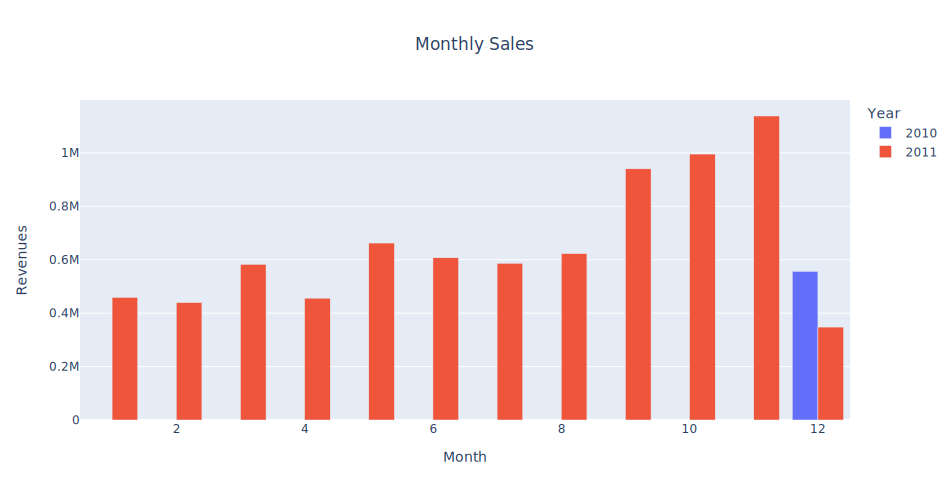

In [140]:
fig = px.bar(monthly_sales,  x='Month', y='TotalExp', barmode  = "group",  color= "Year",  title = "Monthly Sales")
fig.update_layout(yaxis_title = "Revenues", title_x=0.5, width = 950)
fig.show("svg")

In [114]:
daily_sales = grouped_sales.groupby("DayofWeek",as_index=False)["TotalExp"].sum()\
                           .rename(columns = {'DayofWeek':'Weekday', "TotalExp":"Total Revenues"})
daily_sales["Weekday"] = daily_sales.Weekday+1
daily_sales

,Weekday,Total Revenues
0,1,1331224.431
1,2,1574779.921
2,3,1559927.450
3,4,1916125.580
4,5,1240611.561
5,7,773512.181


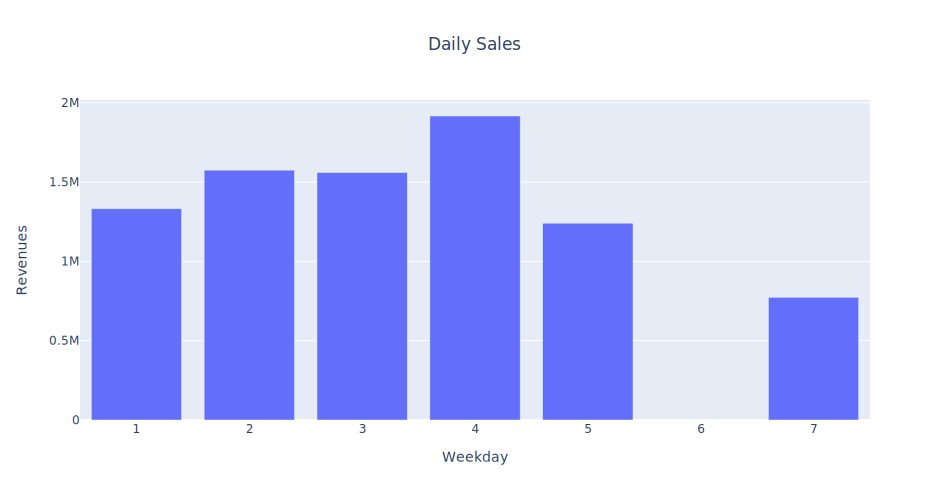

In [142]:
fig = px.bar(daily_sales,  x='Weekday', y='Total Revenues', barmode  = "group",  
             title = "Daily Sales")
fig.update_layout(xaxis_title = "Weekday" , yaxis_title = "Revenues", title_x=0.5, width = 950)
fig.show("svg")

### Customers and Orders Analysis

In [117]:
Customers = df_clean.groupby(["CustomerID", "Country"], as_index=False)\
                      .agg({"InvoiceDate": "max", "InvoiceNo": pd.Series.nunique,
                            "Quantity": "sum", "TotalExp":"sum"})\
          .rename(columns = {"InvoiceDate":"LatestOrderDate", "InvoiceNo":"NumOrders",
                             "Quantity":"Sum_Quantity", "TotalExp":"Total_Expenditure"})

In [118]:
Customers.head()

,CustomerID,Country,LatestOrderDate,NumOrders,Sum_Quantity,Total_Expenditure
0,12347,Iceland,2011-12-07 15:52:00,7,2458,4310.00
1,12348,Finland,2011-09-25 13:13:00,4,2341,1797.24
2,12349,Italy,2011-11-21 09:51:00,1,631,1757.55
3,12350,Norway,2011-02-02 16:01:00,1,197,334.40
4,12352,Norway,2011-11-03 14:37:00,7,473,2385.71


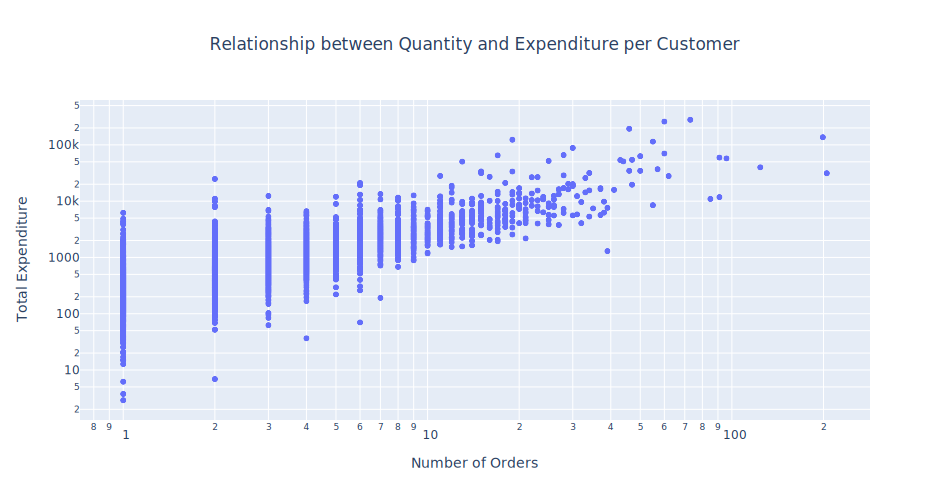

In [331]:
fig = px.scatter(Customers, x="NumOrders", y = 'Total_Expenditure', 
                  log_x = True,  log_y = True, title = "Relationship between Quantity and Expenditure per Customer")
fig.update_layout(xaxis_title = "Number of Orders" , yaxis_title = "Total Expenditure", title_x=0.5, width = 950)
#fig.show()
pio.write_image(fig, 'scatter_order_exp.svg')
display(SVG("scatter_order_exp.svg"))


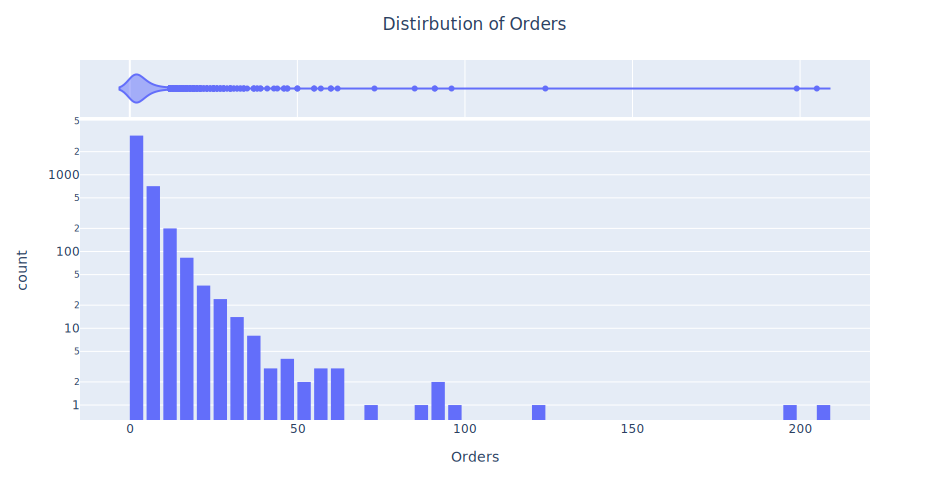

In [190]:
fig = px.histogram(Customers, x="NumOrders", marginal  = "violin",  nbins=50,  log_y = True)
fig.update_layout(title = "Distirbution of Orders", title_x =  0.5, xaxis_title = "Orders", bargap=0.2,  width = 950)
fig.show("svg")

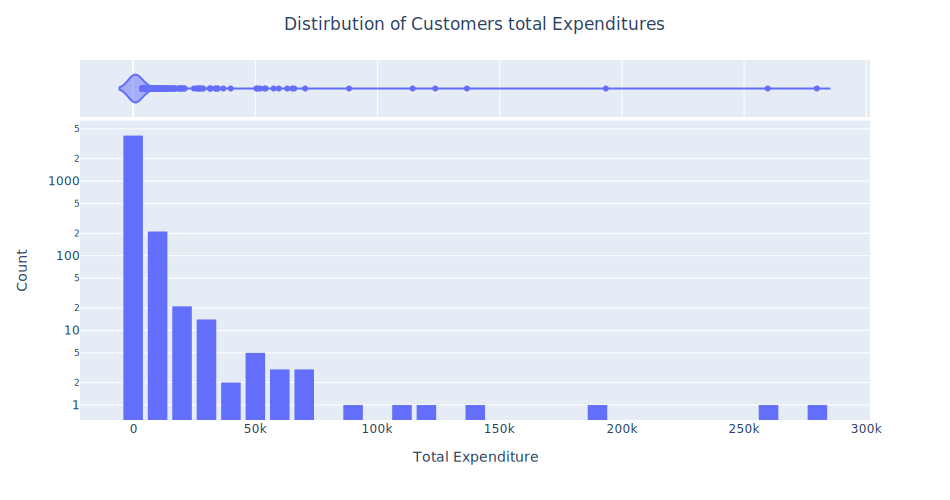

In [210]:
fig = px.histogram(Customers, x="Total_Expenditure", marginal  = "violin",  nbins=50,  log_y = True)
fig.update_layout(title = "Distirbution of Customers total Expenditures", title_x =  0.5, 
                  xaxis_title = "Total Expenditure" , yaxis_title = "Count", bargap=0.2, width = 950)
fig.show("svg")

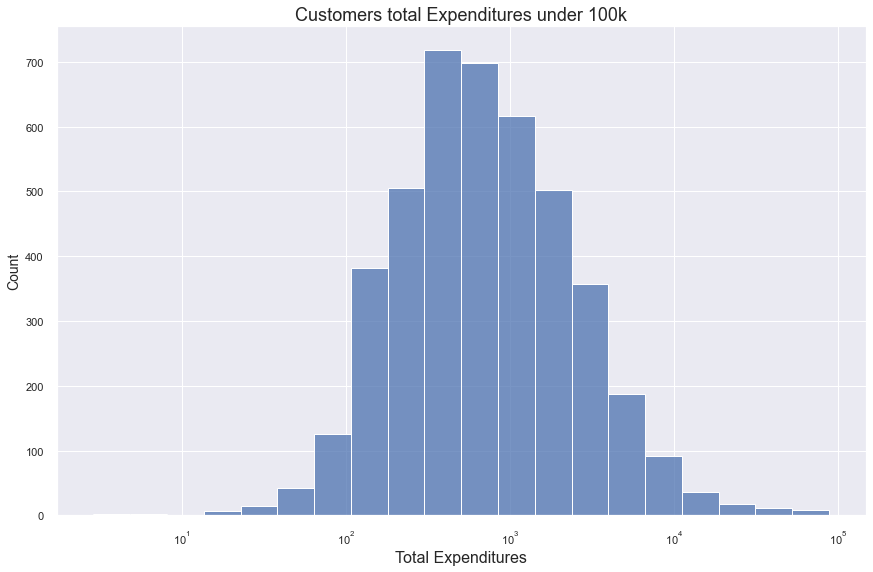

In [258]:
sns.set(rc={'figure.figsize':(14.5,9)})
g = sns.histplot(data=Customers[Customers.Total_Expenditure < 100000], x="Total_Expenditure", log_scale=True, bins = 20)
g.set_title("Customers total Expenditures under 100k", fontsize = 18)
g.set_xlabel("Total Expenditures", fontsize = 16)
g.set_ylabel("Count", fontsize = 14) 
plt.show()

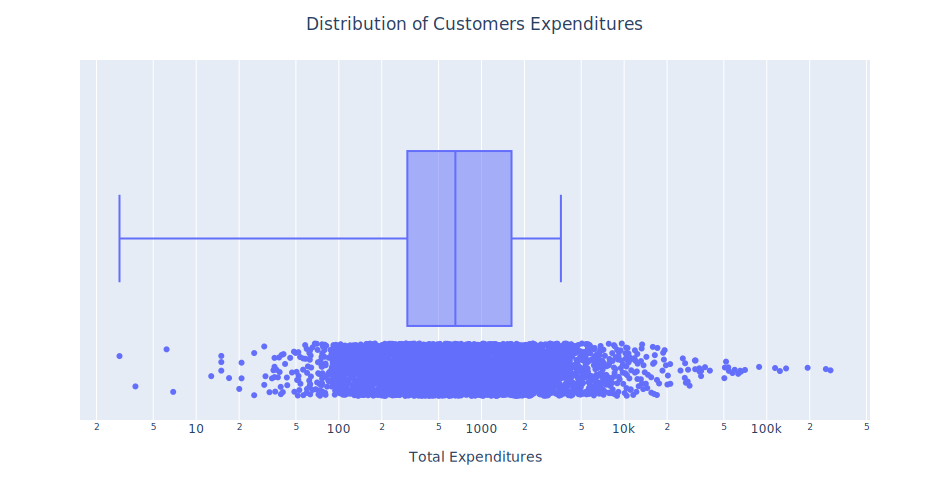

In [151]:
fig = px.box(Customers, x="Total_Expenditure",  points = "all",  orientation = "h", log_x = True)
fig.update_layout(title = "Distribution of Customers Expenditures", xaxis_title = "Total Expenditures", 
                  title_x=0.5, width = 950)
fig.show("svg")

In [342]:
Orders = df_clean.groupby('StockCode', as_index=False)\
          .agg({"InvoiceNo":"count", "Quantity": "sum", "TotalExp":"sum"})\
          .rename(columns = {"InvoiceNo":"NumOrders","Quantity":"SoldQuant", "TotalExp":"TotalRev"})

Orders = Orders[~Orders.StockCode.isin(StockCodeList[:][0])]

In [355]:
# Top 10 Products with the highest revenues.
OrdersRev = Orders.sort_values("TotalRev", ascending=False)

OrdersRev["Share of TotalRev (%)"] = (OrdersRev["TotalRev"]/sum(OrdersRev.TotalRev))*100
OrdersRev["cum TotalRev (%)"] = OrdersRev["Share of TotalRev (%)"].cumsum()

OrdersRev["Share of SoldQuant (%)"] = (OrdersRev["SoldQuant"]/sum(OrdersRev.SoldQuant))*100
OrdersRev["cum SoldQuant (%)"] = OrdersRev["Share of SoldQuant (%)"].cumsum()
OrdersRev.head(10)

,StockCode,NumOrders,SoldQuant,TotalRev,Share of TotalRev (%),cum TotalRev (%),Share of SoldQuant (%),cum SoldQuant (%)
1286,22423,1678,11696,134549.05,1.628111,1.628111,0.238843,0.238843
3228,85123A,2013,34190,93936.30,1.136676,2.764787,0.698192,0.937035
3214,85099B,1606,45088,83282.05,1.007754,3.772541,0.920739,1.857774
2590,47566,1380,15021,67667.33,0.818808,4.591350,0.306743,2.164516
3054,84879,1392,35217,56336.97,0.681705,5.273055,0.719164,2.883680
1917,23084,820,27046,51048.11,0.617708,5.890763,0.552304,3.435985
2745,79321,519,9566,45915.41,0.555599,6.446362,0.195347,3.631331
983,22086,997,15224,41645.48,0.503931,6.950293,0.310888,3.942219
375,21137,311,11388,38997.41,0.471888,7.422181,0.232554,4.174773
1086,22197,1057,48731,36886.17,0.446341,7.868522,0.995132,5.169905


In [356]:
# Top 10 most sold Products.
OrdersQuant = Orders.sort_values("SoldQuant", ascending=False)

OrdersQuant["Share of TotalRev (%)"] = (OrdersQuant["TotalRev"]/sum(OrdersQuant.TotalRev))*100
OrdersQuant["cum TotalRev (%)"] = OrdersQuant["Share of TotalRev (%)"].cumsum()

OrdersQuant["Share of SoldQuant (%)"] = (OrdersQuant["SoldQuant"]/sum(OrdersQuant.SoldQuant))*100
OrdersQuant["cum SoldQuant (%)"] = OrdersQuant["Share of SoldQuant (%)"].cumsum()

OrdersQuant.head(10)

,StockCode,NumOrders,SoldQuant,TotalRev,Share of TotalRev (%),cum TotalRev (%),Share of SoldQuant (%),cum SoldQuant (%)
2800,84077,468,53119,13287.21,0.160782,0.160782,1.084739,1.084739
1086,22197,1057,48731,36886.17,0.446341,0.607123,0.995132,2.079872
3214,85099B,1606,45088,83282.05,1.007754,1.614877,0.920739,3.000610
3054,84879,1392,35217,56336.97,0.681705,2.296583,0.719164,3.719774
3228,85123A,2013,34190,93936.30,1.136676,3.433259,0.698192,4.417966
422,21212,1044,33431,16250.69,0.196641,3.629900,0.682692,5.100658
1917,23084,820,27046,51048.11,0.617708,4.247608,0.552304,5.652962
1350,22492,321,25882,15913.14,0.192557,4.440165,0.528534,6.181497
1467,22616,391,25305,7253.61,0.087772,4.527937,0.516752,6.698248
908,21977,673,24133,11557.65,0.139853,4.667790,0.492818,7.191067


In [438]:
OrdersRev.describe(describe_quant)

,NumOrders,SoldQuant,TotalRev,Share of TotalRev (%),cum TotalRev (%),Share of SoldQuant (%),cum SoldQuant (%)
count,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000
mean,106.603018,1343.466941,2267.248848,0.027435,87.123220,0.027435,81.692033
std,160.450035,2948.643888,5423.165500,0.065623,18.920606,0.060214,22.700670
min,1.000000,1.000000,0.420000,0.000005,1.628111,0.000020,0.238843
1%,1.000000,1.000000,2.550000,0.000031,17.035287,0.000020,11.231209
5%,2.000000,4.000000,11.316000,0.000137,43.182995,0.000082,31.156092
25%,12.000000,65.000000,127.500000,0.001543,82.835944,0.001327,70.994032
50%,48.000000,387.000000,621.150000,0.007516,95.803558,0.007903,91.855562
75%,134.000000,1390.000000,2027.030000,0.024528,99.508422,0.028385,99.221738
95%,396.000000,5861.600000,9822.000000,0.118851,99.987675,0.119699,99.972660


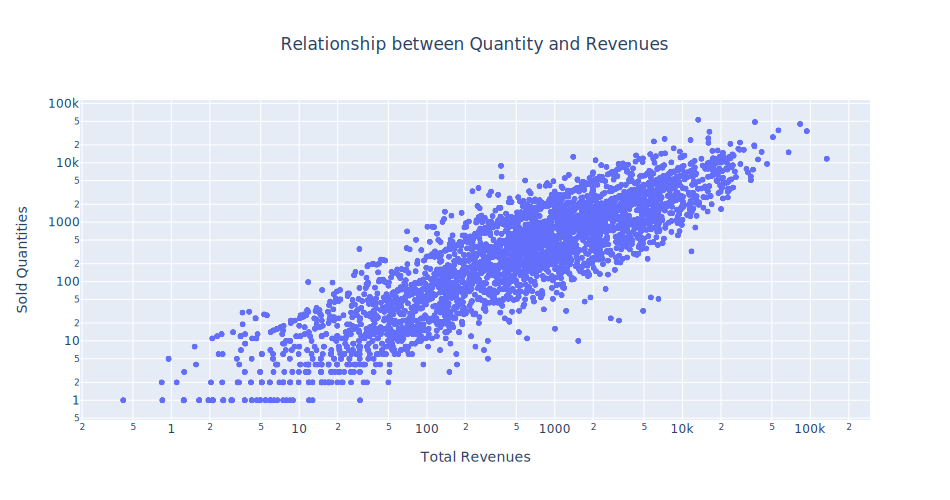

In [370]:
fig = px.scatter(Orders, x="TotalRev", y = 'SoldQuant', 
                  log_x = True,  log_y = True, title = "Relationship between Quantity and Revenues")
fig.update_layout(xaxis_title = "Total Revenues", yaxis_title = "Sold Quantities", title_x=0.5, width = 950)
#fig.show()
pio.write_image(fig, 'scatter_order_exp.svg')
display(SVG("scatter_order_exp.svg"))


In [371]:
Customers.head()

,CustomerID,Country,LatestOrderDate,NumOrders,Sum_Quantity,Total_Expenditure
0,12347,Iceland,2011-12-07 15:52:00,7,2458,4310.00
1,12348,Finland,2011-09-25 13:13:00,4,2341,1797.24
2,12349,Italy,2011-11-21 09:51:00,1,631,1757.55
3,12350,Norway,2011-02-02 16:01:00,1,197,334.40
4,12352,Norway,2011-11-03 14:37:00,7,473,2385.71


## RFM Analysis

### Preparing

In [464]:
RFM_Model = Customers.iloc[:, [0,2,3,5]]
RFM_Model.insert(2, "end_timestamp", pd.Timestamp("2011-12-10 00:00:00"))
RFM_Model.head()

,CustomerID,LatestOrderDate,end_timestamp,NumOrders,Total_Expenditure
0,12347,2011-12-07 15:52:00,2011-12-10,7,4310.00
1,12348,2011-09-25 13:13:00,2011-12-10,4,1797.24
2,12349,2011-11-21 09:51:00,2011-12-10,1,1757.55
3,12350,2011-02-02 16:01:00,2011-12-10,1,334.40
4,12352,2011-11-03 14:37:00,2011-12-10,7,2385.71


In [465]:
RFM_Model['diff'] = round(((RFM_Model['end_timestamp']-RFM_Model['LatestOrderDate']).dt.total_seconds()/86400), 2)
RFM_Model.drop(["LatestOrderDate", "end_timestamp"], axis=1, inplace=True)

In [466]:
RFM_Model.head()

,CustomerID,NumOrders,Total_Expenditure,diff
0,12347,7,4310.00,2.34
1,12348,4,1797.24,75.45
2,12349,1,1757.55,18.59
3,12350,1,334.40,310.33
4,12352,7,2385.71,36.39


In [467]:
RFM_Model = RFM_Model.loc[:,("CustomerID", "diff", "NumOrders", "Total_Expenditure")]\
                     .rename(columns={"diff":"R", "NumOrders":"F", "Total_Expenditure":"M"})
RFM_Model.head()

,CustomerID,R,F,M
0,12347,2.34,7,4310.00
1,12348,75.45,4,1797.24
2,12349,18.59,1,1757.55
3,12350,310.33,1,334.40
4,12352,36.39,7,2385.71


In [468]:
RFM = RFM_Model.drop("CustomerID", axis=1)

### PCA

In [377]:
std_data = StandardScaler().fit_transform(RFM) # normalizing the data 
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(std_data)

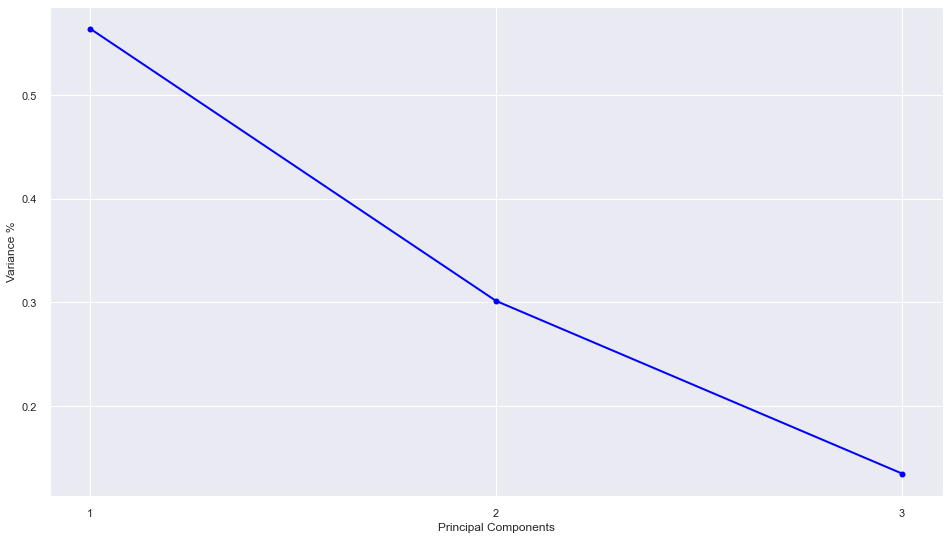

In [389]:
PC = range(1, pca.n_components_+1)
#plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.figure(figsize=(16,9))
plt.plot(PC, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

In [379]:
pca_out = PCA().fit(std_data)

# Get the component variance
# Proportion of Variance (from PC1 to PC3)
pca_out.explained_variance_ratio_.cumsum()

array([0.56401699, 0.86530346, 1.        ])

In [ ]:
Centered_plot = HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

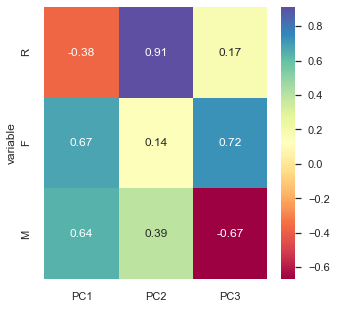

In [455]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_

pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]

loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = RFM.columns.values
loadings_df = loadings_df.set_index('variable')

sns.set(rc={'figure.figsize':(5,5)})
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()
Centered_plot

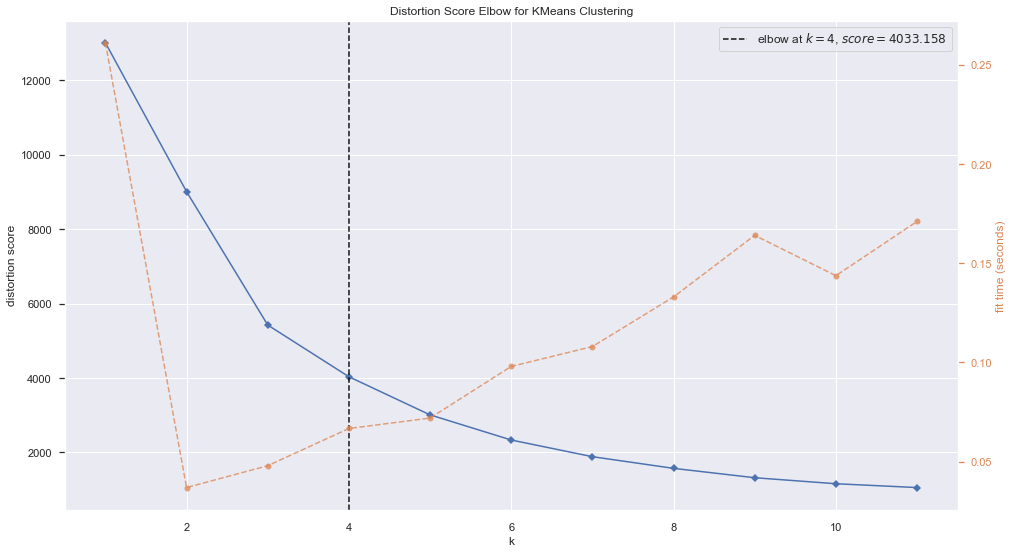

In [458]:
sns.set(rc={'figure.figsize':(16,9)})
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(PCA_components)        # Fit the data to the visualizer
visualizer.finalize()        # Finalize and render the figure

In [459]:
model = KMeans(n_clusters=4, random_state=0)
model.fit(PCA_components)

labels = model.predict(PCA_components)

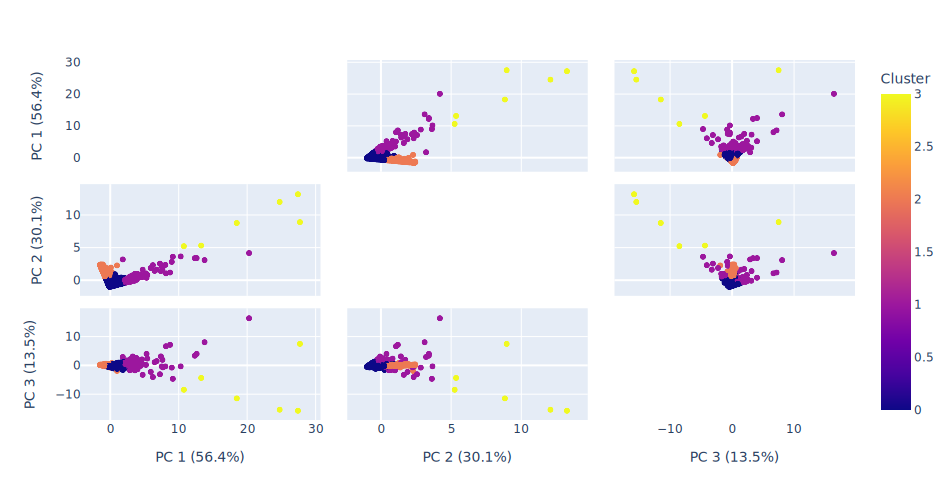

In [460]:
lab= {str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)}

lab['color'] = 'Cluster'

fig = px.scatter_matrix(principalComponents, labels=lab, dimensions=range(3),  color = labels)
fig.update_traces(diagonal_visible=False)
fig.update_layout(width = 950)
#fig.show()
pio.write_image(fig, 'PCA_matrix.svg')
display(SVG("PCA_matrix.svg"))

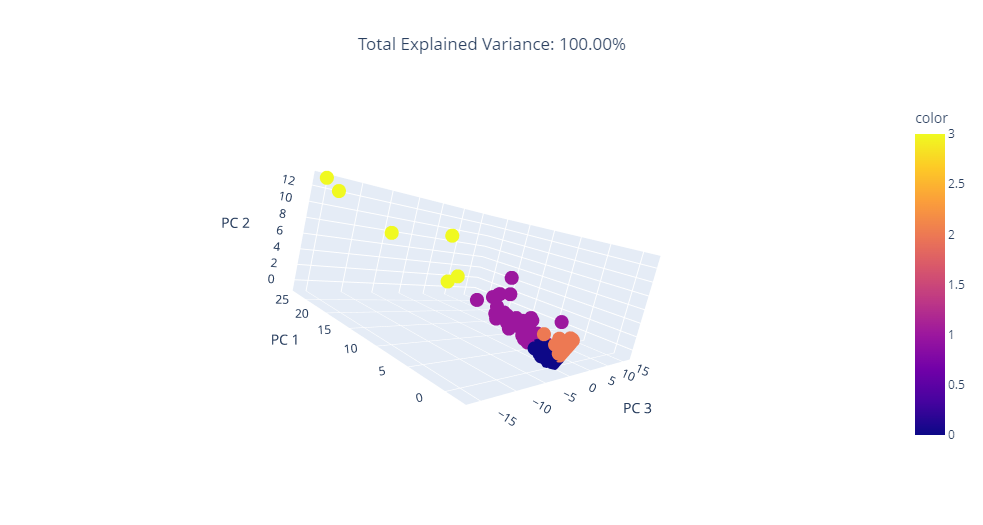

In [462]:
total_var = pca.explained_variance_ratio_.sum() * 100
pio.renderers.default = "notebook"

fig = px.scatter_3d(
    principalComponents, x=0, y=1, z=2, color=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}, 
)
fig.update_layout(title_x=0.5)
#fig.show()
Image("PCA_3d.png")

### Clusters Insights

In [469]:
RFM_Model.insert(4, "cluster", labels.reshape(-1,1))

In [470]:
RFM_Model.cluster = RFM_Model.cluster + 1

In [471]:
RFM_Model.head()

,CustomerID,R,F,M,cluster
0,12347,2.34,7,4310.00,1
1,12348,75.45,4,1797.24,1
2,12349,18.59,1,1757.55,1
3,12350,310.33,1,334.40,3
4,12352,36.39,7,2385.71,1


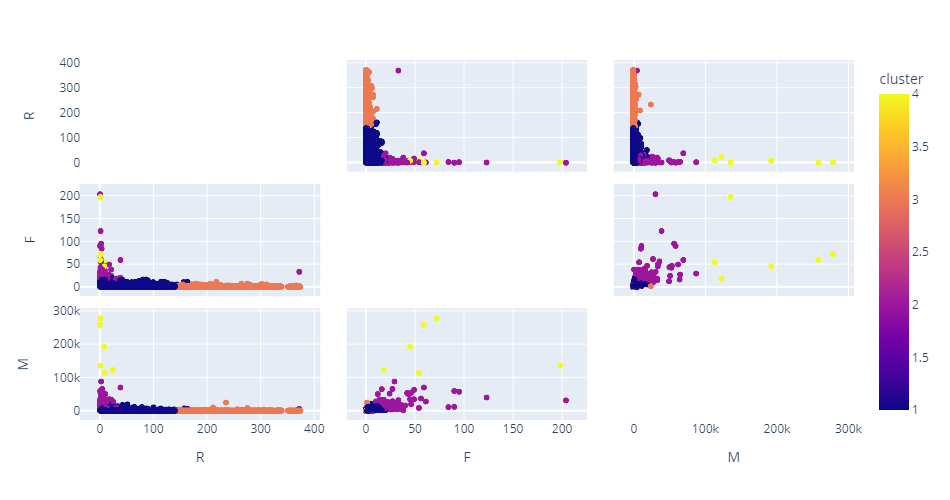

In [483]:
fig = px.scatter_matrix(RFM_Model.drop(columns="CustomerID"), labels=["R", "F", "M"], dimensions=["R", "F", "M"],  color = "cluster")
fig.update_traces(diagonal_visible=False)
fig.update_layout(width = 950)
fig.show("png")
# pio.write_image(fig, 'PCA_matrix.png')
# Image("PCA_matrix.png")

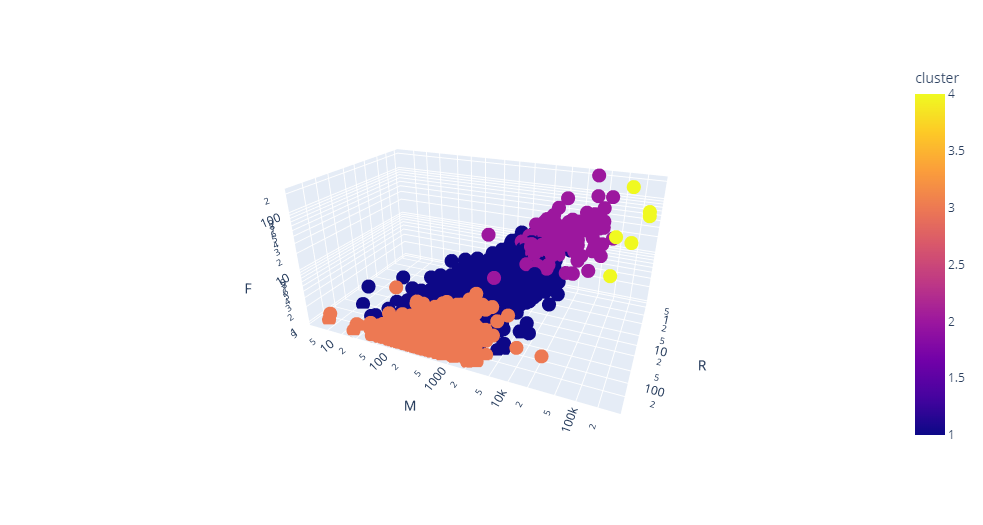

In [476]:
fig = px.scatter_3d(RFM_Model, x="R", y="M", z="F", log_x = True, log_y = True, log_z=True, color="cluster")
#fig.show()
Image("Clusters_3d.png")


In [477]:
RFM_Model.groupby("cluster").mean()

,R,F,M
cluster,,,
1,42.520280,4.052263,1496.499064
2,10.021204,32.944444,19105.683981
3,247.542853,1.543860,488.762337
4,7.621667,75.333333,184570.596667


**Clusters Ranking**

In [478]:
# Gaining insights in the generated clusters.
RFM_Model.groupby("cluster").agg({"R":"mean", "F":"mean", "M":"mean", "CustomerID":"count"})\
                            .rename(columns = {'CustomerID':'Count'}).sort_values(["R", "F", "M"])

,R,F,M,Count
cluster,,,,
4,7.621667,75.333333,184570.596667,6
2,10.021204,32.944444,19105.683981,108
1,42.520280,4.052263,1496.499064,3138
3,247.542853,1.543860,488.762337,1083


In [479]:
RFM_Model.describe(describe_quant)

,R,F,M,cluster
count,4335.000000,4335.000000,4335.000000,4335.000000
mean,92.882484,4.244060,1936.835323,1.528720
std,100.285093,7.624944,8386.306140,0.870235
min,0.470000,1.000000,2.900000,1.000000
1%,1.250000,1.000000,51.709600,1.000000
5%,2.600000,1.000000,110.884000,1.000000
25%,17.545000,1.000000,302.185000,1.000000
50%,50.600000,2.000000,656.250000,1.000000
75%,143.375000,5.000000,1624.175000,3.000000
95%,311.821000,13.000000,5669.069000,3.000000


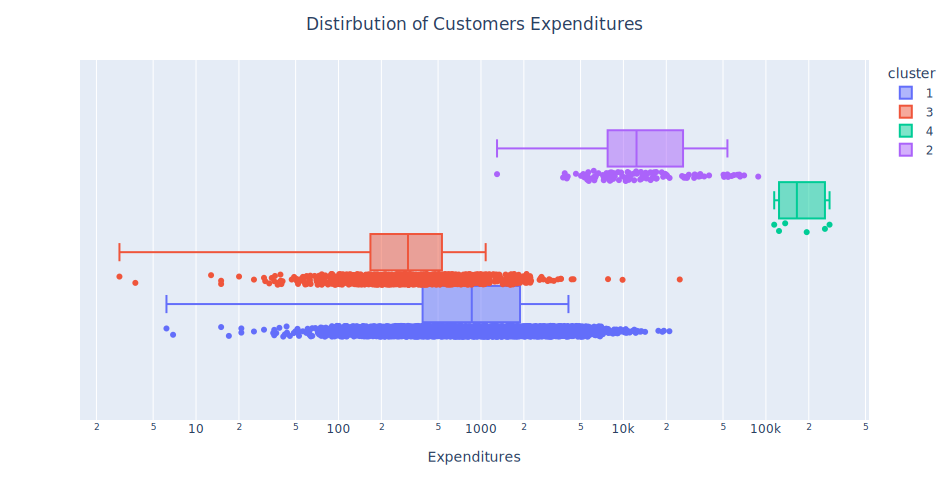

In [480]:
fig = px.box(RFM_Model, x="M", points = "all",  orientation = "h", log_x = True, color="cluster")
fig.update_layout(title = "Distirbution of Customers Expenditures", title_x =  0.5, 
                  xaxis_title = "Expenditures", bargap=0.2,  width = 950)
#fig.show()
pio.write_image(fig, 'box_rfm.svg')
display(SVG("box_rfm.svg"))